In [5]:
# !pip install transformers accelerate
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image
import numpy as np
import torch

init_image = load_image(
    "https://huggingface.co/datasets/diffusers/test-arrays/resolve/main/stable_diffusion_inpaint/boy.png"
)
init_image = init_image.resize((512, 512))

generator = torch.Generator(device="cpu").manual_seed(1)

mask_image = load_image(
    "https://huggingface.co/datasets/diffusers/test-arrays/resolve/main/stable_diffusion_inpaint/boy_mask.png"
)
mask_image = mask_image.resize((512, 512))


def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image


control_image = make_inpaint_condition(init_image, mask_image)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# generate image
image = pipe(
    "a handsome man with ray-ban sunglasses",
    num_inference_steps=20,
    generator=generator,
    eta=1.0,
    image=init_image,
    mask_image=mask_image,
    control_image=control_image,
).images[0]


safety_checker\model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


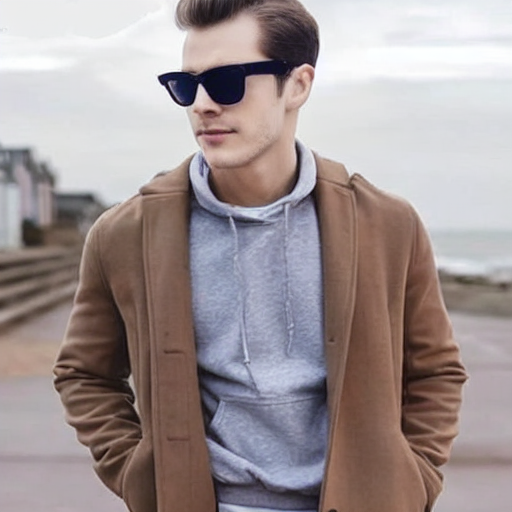

In [4]:
image